In [1]:
import csv
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import sys

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from torch.utils.data import DataLoader, TensorDataset
from itertools import islice
from IPython.display import display, clear_output

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW

# Process Datasets

In [2]:
def Process_dataset (file, Away):
    df = pd.read_csv(file, skiprows = [0,1])
    df = df.iloc[::25]
    
    for index, line in enumerate(df.iterrows()):
        row_tensor = torch.tensor(df.iloc[index, :25].values)
        out_player = torch.where(torch.isnan(row_tensor))[0]
        out_player = df.columns[out_player]    
        sub_players = df.iloc[index, 25:df.shape[1]-2]
        in_player =  sub_players.index[sub_players.notnull()]
        subset_df = df.iloc[index:, :]
        if  not out_player.empty:
            #print(line)
            print(out_player[0], " replaced by ", in_player[0], " at time [s] : ", df.iloc[index,2])
            in_player_index_label = in_player[0]
            out_player_index_label = out_player[0]
            subset_df = df.iloc[index:, :].copy()
            subset_df[in_player_index_label], subset_df[out_player_index_label] = subset_df[out_player_index_label].values, subset_df[in_player_index_label].values
            df.iloc[index:, :] = subset_df
    
            in_player_index_label = in_player[1]
            out_player_index_label = out_player[1]
            subset_df = df.iloc[index:, :].copy()
            subset_df[in_player_index_label], subset_df[out_player_index_label] = subset_df[out_player_index_label].values, subset_df[in_player_index_label].values
            df.iloc[index:, :] = subset_df
    
    
    df = df.interpolate(method='linear', axis=0, limit_direction='both')
    df = df.dropna(axis=1)

    
    
    
    concatenated_df = pd.DataFrame()
    
    # Iterate over pairs of columns and concatenate them into a new column of vector entries
    for i in range(3, len(df.columns) - 1, 2):
        column1 = df.columns[i]
        column2 = df.columns[i + 1]
        if Away:
            new_column_name = f'Player_{int(i/2)+11}'
        else:
            new_column_name = f'Player_{int(i/2)}'
        if i == 25:
            new_column_name = "Ball"
        concatenated_column = df[[column1, column2]].apply(lambda x: torch.tensor(x.values.tolist()), axis=1)
        concatenated_df[new_column_name] = concatenated_column
    
    first_3_columns = df.iloc[:, :3]
    df = pd.concat([first_3_columns, concatenated_df ], axis=1)
    
    return df

In [3]:

Home_team = Process_dataset('C:/Users/user/Notebooks/Soccer Valuation/Sample_Game_1_RawTrackingData_Home_Team.csv', Away = False)
Away_team = Process_dataset('C:/Users/user/Notebooks/Soccer Valuation/Sample_Game_1_RawTrackingData_Away_Team.csv', Away = True)
home_team_subset = Home_team.iloc[:, :-1]
away_team_subset = Away_team.iloc[:, 3:]
Game_dataset = pd.concat([home_team_subset, away_team_subset], axis=1)
Game_dataset.reset_index(drop=True, inplace=True)

exclude_columns = ['Period', 'Frame', 'Time [s]']
for index, row in Game_dataset.iterrows():
    seen_values = []
    for column, value in row.items():
        if column not in exclude_columns:
            #Multiply by football width and length
            Game_dataset.at[index, column] *= torch.tensor([105,68])
            
            #Switch coordinates for second half time
            if Game_dataset.iloc[index,0]==2:
                pos_x = Game_dataset.at[index,column][0]
                Game_dataset.at[index,column][0] = 105 - pos_x

            #Assure nobody is at the same place
            for seen in seen_values:
                if seen[0]==value[0]:
                    value[0]+=0.0001
                if seen[1]==value[1]:
                    value[1]+=0.0001
                Game_dataset.at[index, column] = value
            seen_values.append(value)
                    
           
Game_dataset.head()

Player1  replaced by  Player12  at time [s] :  1869.04
Player6  replaced by  Player13  at time [s] :  4434.04
Player10  replaced by  Player14  at time [s] :  4856.04
Player24  replaced by  Player26  at time [s] :  4264.04
Player22  replaced by  Player27  at time [s] :  4275.04
Player19  replaced by  Player28  at time [s] :  4776.04


,Period,Frame,Time [s],Player_1,Player_2,Player_3,Player_4,Player_5,Player_6,Player_7,...,Player_14,Player_15,Player_16,Player_17,Player_18,Player_19,Player_20,Player_21,Player_22,Ball
0,1,1,0.04,"[tensor(0.0861), tensor(32.8018)]","[tensor(34.2804), tensor(44.4190)]","[tensor(35.3861), tensor(33.2268)]","[tensor(32.4734), tensor(24.1597)]","[tensor(33.7439), tensor(14.4582)]","[tensor(43.1487), tensor(49.3605)]","[tensor(43.7829), tensor(32.5332)]",...,"[tensor(71.0409), tensor(31.7628)]","[tensor(70.6755), tensor(52.0037)]","[tensor(42.8222), tensor(41.8370)]","[tensor(47.7456), tensor(26.3221)]","[tensor(58.7580), tensor(46.0870)]","[tensor(58.0052), tensor(29.4230)]","[tensor(52.5704), tensor(64.1390)]","[tensor(45.8777), tensor(3.4014)]","[tensor(39.7246), tensor(18.6204)]","[tensor(47.7457), tensor(26.3222)]"
1,1,26,1.04,"[tensor(0.0672), tensor(32.7298)]","[tensor(34.0053), tensor(42.3082)]","[tensor(34.9282), tensor(32.3877)]","[tensor(33.0886), tensor(23.1520)]","[tensor(34.0358), tensor(12.4488)]","[tensor(43.4196), tensor(47.1981)]","[tensor(43.0605), tensor(30.6714)]",...,"[tensor(69.8502), tensor(30.4456)]","[tensor(68.8664), tensor(50.0827)]","[tensor(41.2766), tensor(39.2986)]","[tensor(47.0505), tensor(23.6205)]","[tensor(59.4289), tensor(43.0080)]","[tensor(55.8253), tensor(28.5512)]","[tensor(51.5676), tensor(63.5406)]","[tensor(43.8795), tensor(2.0291)]","[tensor(37.0839), tensor(19.8975)]","[tensor(59.5413), tensor(13.5334)]"
2,1,51,2.04,"[tensor(-0.0210), tensor(32.6577)]","[tensor(33.4646), tensor(39.6528)]","[tensor(34.3529), tensor(31.3099)]","[tensor(33.1832), tensor(22.3808)]","[tensor(33.2734), tensor(11.1534)]","[tensor(43.5435), tensor(44.7243)]","[tensor(43.0437), tensor(28.7300)]",...,"[tensor(68.1744), tensor(28.5518)]","[tensor(66.3212), tensor(46.9023)]","[tensor(39.0674), tensor(36.5888)]","[tensor(47.0662), tensor(21.1562)]","[tensor(58.9995), tensor(38.8470)]","[tensor(52.9242), tensor(28.3696)]","[tensor(49.6461), tensor(63.0251)]","[tensor(41.2598), tensor(1.4430)]","[tensor(35.0049), tensor(21.4622)]","[tensor(53.9280), tensor(15.7359)]"
3,1,76,3.04,"[tensor(0.1019), tensor(32.6890)]","[tensor(33.4981), tensor(38.0059)]","[tensor(34.3759), tensor(31.4452)]","[tensor(33.3091), tensor(23.5430)]","[tensor(32.5343), tensor(11.8245)]","[tensor(43.3020), tensor(43.0658)]","[tensor(43.5771), tensor(27.9997)]",...,"[tensor(65.7773), tensor(27.2598)]","[tensor(63.3581), tensor(44.6950)]","[tensor(37.9008), tensor(35.0139)]","[tensor(47.5387), tensor(21.5308)]","[tensor(57.1210), tensor(35.6000)]","[tensor(51.2400), tensor(29.8153)]","[tensor(47.0516), tensor(63.1407)]","[tensor(38.6022), tensor(2.3290)]","[tensor(34.5660), tensor(23.4756)]","[tensor(47.5209), tensor(21.4574)]"
4,1,101,4.04,"[tensor(0.7434), tensor(32.8012)]","[tensor(34.1355), tensor(39.0646)]","[tensor(34.6699), tensor(33.4438)]","[tensor(33.7407), tensor(25.8570)]","[tensor(33.2766), tensor(13.8428)]","[tensor(42.7760), tensor(43.6308)]","[tensor(42.5208), tensor(29.5732)]",...,"[tensor(64.1077), tensor(27.5386)]","[tensor(60.8895), tensor(45.6321)]","[tensor(37.8294), tensor(35.7394)]","[tensor(47.7519), tensor(23.7640)]","[tensor(55.0431), tensor(35.8680)]","[tensor(50.9534), tensor(32.9535)]","[tensor(43.5309), tensor(63.6664)]","[tensor(36.3227), tensor(4.4125)]","[tensor(35.2737), tensor(25.3218)]","[tensor(50.9628), tensor(32.7984)]"


# Create States

### Average Compositions
First the average compositions need to be computed for both the home and away team

In [4]:
#Finds the most common composition in a list of Compositions
def most_common_element(lst):
    counts = {}  # Dictionary to store counts of each tensor
    max_count = 0
    most_common = None

    # Define a function to convert tensor to a hashable representation (tuple)
    def tensor_to_tuple(tensor):
        return tuple(tensor.flatten().tolist())

    # Iterate through the list and count occurrences of each tensor
    for tensor in lst:
        tensor_tuple = tensor_to_tuple(tensor)
        counts[tensor_tuple] = counts.get(tensor_tuple, 0) + 1
        if counts[tensor_tuple] > max_count:
            max_count = counts[tensor_tuple]
            most_common = tensor

    return most_common


# returns the list of compositions of the team 
def compute_compositions(team, df):
    if team == "Home":
        i  = 4
        j = 14
    else:
        i = 15
        j = 25
    
    Compositions = []
    for t in range(df.shape[0]):
        Team = df.iloc[t, i:j]
        Compositions.append(get_relative_positions(Team, df, t))
    return Compositions



#Gets the relative positions matrix given a list of players
def get_relative_positions(players, df, t):
    n = len(players)
    mat = torch.zeros(n,n)
    sorted_x = sorted(players, key=lambda x: x[0])
    sorted_y= sorted(players, key=lambda x: x[1])
    for player in players:
        i = [a for a, tensor in enumerate(sorted_y) if torch.all(torch.eq(tensor, player))][0]
        j = [a for a, tensor in enumerate(sorted_x) if torch.all(torch.eq(tensor, player))][0]
        player_nb = get_player_nb(player, df, t)
        mat[i][j] = player_nb
       
    return mat



def mirror_matrix(matrix):
    mirrored_matrix = []
    for row in matrix:
        mirrored_row = list(reversed(row))  # Reverse the order of columns in the row
        mirrored_matrix.append(mirrored_row)
    return mirrored_matrix

def switch_columns(tensor):
    # Get the number of columns in the tensor
    num_columns = tensor.shape[1]
    
    # Reverse the order of columns using torch.flip
    reversed_tensor = torch.flip(tensor, dims=[1])
    
    return reversed_tensor

    
def place_in_compo(role):
    #role = torch.floor((role/2).clone().detach().requires_grad_(True))
    i,j = role 
    i -= 1
    j -= 1
    return int(5*j + i) + 2


def get_team_label(i):
    if i >= 1 and i <= 11:
        return 1
    elif i >= 12 and i <= 22:
        return -1
    elif i == 23:
        return 23
    else:
        raise ValueError("i should be between 1 and 23")


def get_player_nb(player, df, t):
    index = 0
    for column in df.columns:
        if (df.iloc[t, index] == player).all():
            column_name = column
            if column_name == "Ball":
                return 23
            else:
                player_nb = int(column_name.split('_')[1])
            return player_nb
        index+=1


def shift_and_replace(matrix, new_row):
    n = matrix.shape[0]
    for i in range(n-1):
        matrix[i] = matrix[i+1]
    matrix[-1] = new_row
    return matrix


'\ndef shift_and_replace(matrix, new_row):\n    n = matrix.shape[0]\n    for i in range(n-1, 1, -1):\n        matrix[i] = matrix[i-1]\n    matrix[0] = new_row\n    return matrix\n'

In [5]:

Compos_home = compute_compositions("Home", Game_dataset)
Compos_away = compute_compositions("Away", Game_dataset)
avg_compo_home = most_common_element(Compos_home)
avg_compo_away = most_common_element(Compos_away)
avg_compo_away = switch_columns(avg_compo_away)
avg_compo_ball = torch.full((1, 1), 23)
torch.save(avg_compo_home, 'avg_compo_home.pt')
torch.save(avg_compo_away, 'avg_compo_away.pt')

REL = []
for t in range(len(Game_dataset)-1):
    players = Game_dataset.iloc[t, 3:26]
    REL.append(get_relative_positions(players, Game_dataset, t))
torch.save(REL, 'REL.pt')

"""
avg_compo_home = torch.load('avg_compo_home.pt')
avg_compo_away = torch.load('avg_compo_away.pt')
REL = torch.load('REL.pt')
"""

### Features dataset
Dataset storing the all the informations of each player at each time

In [49]:
Delta = 1
# Compute the features dataset
Game_dataset.rename(columns={Game_dataset.columns[-1]: "Player_23"}, inplace=True)
Features_tensor = torch.zeros(len(Game_dataset), 23, 12)


for idx, column in enumerate(Game_dataset.columns[3:]):
    for t, value in Game_dataset[column].items():
        #Player_nb
        player_nb = int(column.split('_')[1])
        #Indexes
        indexes = torch.where(REL[t] == player_nb)
        indexes = torch.tensor(indexes)     
        #Team_label
        team_label =  get_team_label(player_nb)
        #Role
        role = torch.tensor([0,0])
        if player_nb % 11 != 1 :                  #player is neither goalkeeper or goal (player_nb != 1,11,23)
            if team_label == 1:
                team = "home"
            elif team_label==-1:
                team = "away"
            r  = torch.where(globals().get(f"avg_compo_{team}") == player_nb)
            r = torch.floor(torch.tensor(r))
            r = [int(r[0]), int(r[1])]
            role = torch.tensor([int(r[0]/2) + 1, int(r[1]/2) + 1 ])
        #Position
        pos = Game_dataset.iloc[t, 3+idx]
        pos = pos.clone().detach()      
        #Velocity
        vel = torch.tensor([0,0])
        if t > 0:
            vel = (pos - Game_dataset.iloc[t-1, 3+idx]) / Delta
        #Acceleration
        acc = torch.tensor([0,0])
        if t>1:
            acc = (vel - (( Game_dataset.iloc[t-1, 3+idx] - Game_dataset.iloc[t-2, 3+idx]) / Delta)) / Delta

        player_nb = torch.tensor(player_nb).unsqueeze(0)
        team_label = torch.tensor(team_label).unsqueeze(0)
        features = torch.cat((player_nb, indexes, team_label, role, pos, vel, acc), dim=0)   

        Features_tensor[t][idx] = features

        #sys.stdout.write("\rFeatures_Dataset {} / 23 created at {:.2f}%".format(idx+1, t/len(Game_dataset)*100))
        #sys.stdout.flush()
        
torch.save(Features_tensor, 'Features_tensor.pt')

#Features_dataset.head()

#### States Computation

In [16]:
#Compute States
States = []
for  t,row in enumerate(Features_tensor):    
    Mt = torch.zeros((23, 23))
    Mr1 = torch.zeros((23, 23))
    Mr2 = torch.zeros((23, 23))
    Mp1 = torch.zeros((23, 23))
    Mp2 = torch.zeros((23, 23))
    Mv1 = torch.zeros((23, 23))
    Mv2 = torch.zeros((23, 23))
    Ma1 = torch.zeros((23, 23))
    Ma2 = torch.zeros((23, 23))
    for player in row:
        i = int(player[1])
        j = int(player[2])
        Mt[i][j] = player[3]
        Mr1[i][j] = player[4]
        Mr2[i][j] = player[5]
        Mp1[i][j] = player[6]
        Mp2[i][j] = player[7]
        Mv1[i][j] = player[8]
        Mv2[i][j] = player[9]
        Ma1[i][j] = player[10]
        Ma2[i][j] = player[11]

    state = torch.stack([Mt,Mr1, Mr2, Mp1, Mp2, Mv1, Mv2, Ma1, Ma2], axis = 0)

    States.append(state)
    
    percentage = t / Features_tensor.shape[0] * 100
    sys.stdout.write("\rProgress: {:.2f}%".format(percentage))
    sys.stdout.flush()

#States = torch.stack(States)
torch.save(States, 'States.pt')


Progress: 99.98%

# Convolutional Autoencoder

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
         # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(9, 32, kernel_size=3, stride=1, padding=1),  # Input size: 9x23x23, Output size: 32x23x23
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Input size: 32x23x23, Output size: 64x23x23
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Input size: 64x23x23, Output size: 64x11x11
            nn.Flatten(),                                         # Flatten the output into a vector
            nn.Linear(64*11*11, 128),                             # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)                                    # Output layer with 10 units
        )

        
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),                       # Input size: 1x10, Output size: 1x128
            nn.ReLU(),
            nn.Linear(128, 64*11*11),                 # Fully connected layer to match desired shape
            nn.ReLU(),
            nn.Unflatten(1, (64, 11, 11)),            # Reshape the output into a 3D tensor: 64x11x11
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # Transposed convolutional layer: 32x23x23
            nn.ReLU(),
            nn.ConvTranspose2d(32, 9, kernel_size=3, stride=1, padding=0), # Transposed convolutional layer: 9x23x23
            nn.ReLU(),
            nn.ZeroPad2d((0, -1, 0, -1))  # Crop the output to match input size
        )        
        
        
        
    def encode(self, x):
        x = self.encoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [38]:
# Create DataLoader
batch_size = 32
loss_values = []
data_loader = DataLoader(States, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)



# Initialize the Model   
model = ConvAutoencoder()
#model.load_state_dict(torch.load('CAE.pt'))

criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


optimizer = AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)



Encoded_States = []
loss_function = CustomLoss()

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    # Inside the training loop
    for data in data_loader:
        optimizer.zero_grad()
        input_data = data.clone().detach().requires_grad_(True)
        data = data.clone().detach().requires_grad_(True)
        
        #save encoded states for the LSTM
        encoded =  model.encode(data)
        if epoch == num_epochs-1:
            for d in encoded:
                Encoded_States.append(d)
            
        reconstructions= model(input_data)
        loss = criterion(reconstructions, input_data)
        #loss = loss_function(reconstructions, input_data)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_values.append(loss.item())
    epoch_loss = running_loss / len(data_loader)
    scheduler.step(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}")

torch.save(model.state_dict(), 'CAE.pt')
   
print('Finished Training')
torch.save(Encoded_States, 'Encoded_States.pt')





Epoch 1/200, Loss: 22.857447142129416
Epoch 2/200, Loss: 21.466385893769317
Epoch 3/200, Loss: 20.292367987580352
Epoch 4/200, Loss: 19.718205871162834
Epoch 5/200, Loss: 19.200467790876115
Epoch 6/200, Loss: 18.75510823595655
Epoch 7/200, Loss: 18.299758345216187
Epoch 8/200, Loss: 17.894838799487104
Epoch 9/200, Loss: 17.48486064554571
Epoch 10/200, Loss: 17.03162307529659
Epoch 11/200, Loss: 16.59646578673478
Epoch 12/200, Loss: 16.18995962562142
Epoch 13/200, Loss: 15.813326416434823
Epoch 14/200, Loss: 15.39863881436023
Epoch 15/200, Loss: 15.018557496123261
Epoch 16/200, Loss: 14.70278139952775
Epoch 17/200, Loss: 14.371816493652679
Epoch 18/200, Loss: 14.022729753137945
Epoch 19/200, Loss: 13.761597801040818
Epoch 20/200, Loss: 13.473643208598043
Epoch 21/200, Loss: 13.176711433536404
Epoch 22/200, Loss: 12.951075669173356
Epoch 23/200, Loss: 12.683751682658771
Epoch 24/200, Loss: 12.510803542294346
Epoch 25/200, Loss: 12.32918588407747
Epoch 26/200, Loss: 12.179613427801447
Epo

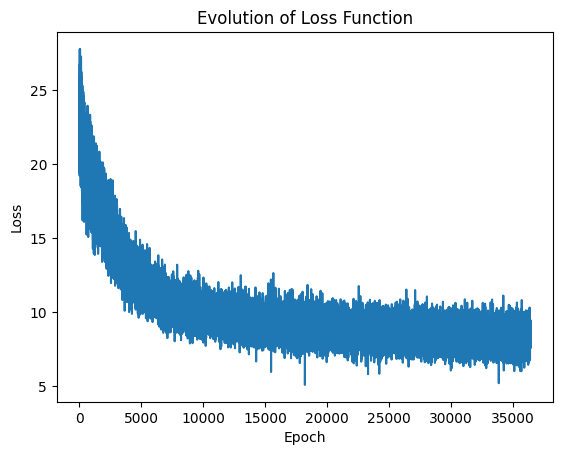

In [39]:
# Plot the evolution of the loss function
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss Function')
plt.show()


# LSTM

### Create Training and Test Datasets for the LSTM models


In [7]:
pitch_length = 105
pitch_width = 68
#Create Dataset
Datasets = [[0,0]] * 27

Delta = 1
n = Features_tensor.shape[0]
T = 10

models = []
for p in range(23):
    if p==0 or p==11:
        m = 1
    elif p == 22:
        m = 27
    else:
        role = Features_tensor[0][p][4:6].clone()
        m = place_in_compo(role)
    models.append(m)

for model in range(1,28):
    indices = [index for index, value in enumerate(models) if value == model]
    k = len(indices)
    X = torch.zeros(n*k, 10, 17)
    Y = torch.zeros(n*k, 2)

    i = 0    
    for p in indices:
        D = torch.zeros(10,17)
        for t in range(i*n, (i+1)*n-1):
            player  = Features_tensor[t - i *n ][p]
            features = player.clone().detach()
            indices_to_suppress = [0, 1, 2, 4, 5]
            mask = torch.ones(features.size(), dtype=torch.bool)
            mask[indices_to_suppress] = False
            features = features[mask]
            if p>=11 and p<=21:
                features = torch.tensor([features[0].item(), pitch_length - features[1].item(), pitch_width - features[2].item(), -1*features[3].item(), -1*features[4].item(), -1*features[5].item(), -1*features[6].item() ])
            input = torch.cat((features, Encoded_States[t - i*n]))
            D = shift_and_replace(D, input)
            X[t] = D
            if p>=11 and p<=21:
                Y[t] = torch.tensor([pitch_length - Features_tensor[t+1 - i*n][p][6].item(), pitch_width - Features_tensor[t+1 - i*n][p][7].item()])
            else:
                Y[t] = Features_tensor[t+1 - i*n][p][6:8]
                
        i += 1

    Datasets[model - 1] = ([X,Y])
    sys.stdout.write("\rDataset {} / 27 created".format(model))
    sys.stdout.flush()
    


torch.save(Datasets, 'Datasets.pt')

Dataset 27 / 27 created

In [117]:
# Define the percentage of data for training and testing
train_ratio = 0.8  

# Initialize lists to store the split datasets
split_datasets = []

# Loop over each dataset
for X, Y in Datasets:
    # Determine the number of samples for training and testing
    num_samples = X.size(0)
    num_train = int(train_ratio * num_samples)
    num_test = num_samples - num_train
        
    # Split the dataset into training and testing sets
    X_train, X_test = X[:num_train], X[num_train:]
    y_train, y_test = Y[:num_train], Y[num_train:]
        
    # Append the split dataset to the list
    split_datasets.append((X_train, y_train, X_test, y_test))

torch.save(split_datasets, 'split_datasets.pt')

### Initialize and train models

In [121]:
# Parameters
input_dim = 17
output_dim = 2
num_units = 512
num_epochs = 50
batch_size = 128
sequence_length = 10



class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_units, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, num_units, batch_first=True) 
        self.fc = nn.Linear(num_units, output_dim)

    def forward(self, x):
        # Forward pass through the LSTM layer
        out, _ = self.lstm(x)
        
        # Extract the output of the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])
        
        return out

In [122]:

# Initialize dictionaries to store losses for each model
train_losses = {}
test_losses = {}


# Initialize and save all models
for i in range(27):
    model = LSTMModel(input_dim, num_units, output_dim)
    torch.save(model.state_dict(), f'LSTMmodel_{i+1}.pt')

# Loop to train and evaluate models
for p, data in enumerate(split_datasets):
    if Datasets[p][0].shape[0] != 0 : 
        X_train, y_train, X_test, y_test = data
        
        # Convert data to PyTorch tensors
        X_train_tensor = X_train.float().clone().detach().requires_grad_(True)
        y_train_tensor = y_train.float().clone().detach().requires_grad_(True)
        X_test_tensor = X_test.float().clone().detach().requires_grad_(True)
        y_test_tensor = y_test.float().clone().detach().requires_grad_(True)
        
        # Create DataLoader for training and testing
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, pin_memory=True)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, pin_memory=True)
        
        # Load the model
        model = LSTMModel(input_dim, num_units, output_dim)
        model.load_state_dict(torch.load(f'LSTMmodel_{p+1}.pt'))
      
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)  # Adding L2 regularization
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.05)
    
        # Lists to store losses for each epoch
        train_losses[p] = []
        test_losses[p] = []
    
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)  # Gradient clipping
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            
            epoch_loss /= len(train_loader.dataset)
            train_losses[p].append(epoch_loss)
            
            #if epoch % 10 == 9:
            print(f"Model {p+1}: epoch {epoch+1} / {num_epochs}, train loss = {epoch_loss:.4f}", flush=True)
            
            # Step the learning rate scheduler
            scheduler.step()
    
    # Evaluate the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses[m] = test_loss
    print(f"Model {p+1} - Test Loss: {test_loss:.4f}")
    
    torch.save(model.state_dict(), f'LSTMmodel_{p+1}.pt')


torch.save(train_losses, 'train_losses.pt')

Model 1: epoch 1 / 50, train loss = 289.4624
Model 1: epoch 2 / 50, train loss = 41.9748
Model 1: epoch 3 / 50, train loss = 40.1000
Model 1: epoch 4 / 50, train loss = 37.4927
Model 1: epoch 5 / 50, train loss = 32.0867
Model 1: epoch 6 / 50, train loss = 22.9419
Model 1: epoch 7 / 50, train loss = 14.7009
Model 1: epoch 8 / 50, train loss = 10.6059
Model 1: epoch 9 / 50, train loss = 8.5276
Model 1: epoch 10 / 50, train loss = 6.9540
Model 1: epoch 11 / 50, train loss = 5.6265
Model 1: epoch 12 / 50, train loss = 4.6699
Model 1: epoch 13 / 50, train loss = 3.8349
Model 1: epoch 14 / 50, train loss = 3.3405
Model 1: epoch 15 / 50, train loss = 2.8125
Model 1: epoch 16 / 50, train loss = 2.4136
Model 1: epoch 17 / 50, train loss = 2.1308
Model 1: epoch 18 / 50, train loss = 1.9698
Model 1: epoch 19 / 50, train loss = 1.8341
Model 1: epoch 20 / 50, train loss = 1.8531
Model 1: epoch 21 / 50, train loss = 1.6776
Model 1: epoch 22 / 50, train loss = 1.6309
Model 1: epoch 23 / 50, train lo

The evolution of the loss function can have 4 different behaviors depending in the model. First, we notice that the best convergence corresponds to the goalkeeper loss, since his behavior is the easiest to understand in a football match. On the contrary, the ball loss has the worst convergence. We observe an other small group of 5 models that converges slightly quicker than the main group. This explains itself because these models ( 4, 11, 12, 21, 23) each corresponds to a player in both home and away team. Thus, these models have a training set that is twice bigger has the others.

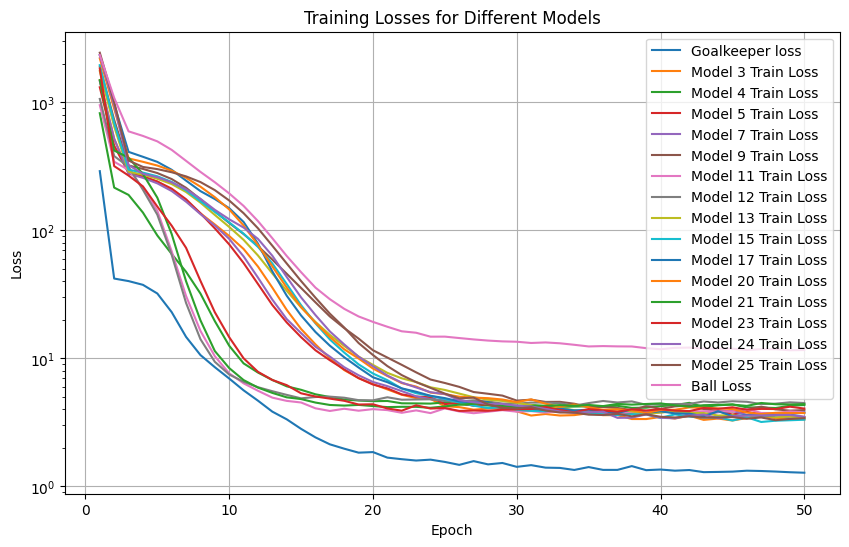

In [123]:
# Plot losses for all models
plt.figure(figsize=(10, 6))
for m, train_loss in train_losses.items():
    m+=1
    if m == 1:
        plt.plot(range(1, len(train_loss) + 1), train_loss, label="Goalkeeper loss")
    elif m == 27:
        plt.plot(range(1, len(train_loss) + 1), train_loss, label="Ball Loss")
    else:
        plt.plot(range(1, len(train_loss) + 1), train_loss, label=f"Model {m} Train Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for Different Models')
plt.legend()
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

# Simulation

In [28]:
"""
Features_tensor = torch.load('Features_tensor.pt')
Datasets = torch.load('Datasets.pt')
States = torch.load('States.pt')
"""

In [19]:
def create_pitch (pitch_length, pitch_width):
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create a rectangle for the football pitch
    pitch_rectangle = patches.Rectangle((0, 0), pitch_length, pitch_width, linewidth=2, edgecolor='green', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(pitch_rectangle)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)

    # Add markings like the center circle, penalty area, and goal area
    center_circle = patches.Circle((pitch_length/2, pitch_width/2), radius=9.15, linewidth=2, edgecolor='green', facecolor='none')
    goal_area1 = patches.Rectangle((0, (pitch_width - 16.5) / 2), 5.5, 16.5, linewidth=2, edgecolor='green', facecolor='none')
    goal_area2 = patches.Rectangle((pitch_length - 5.5, (pitch_width - 16.5) / 2), 5.5, 16.5, linewidth=2, edgecolor='green', facecolor='none')
    middle_line = patches.ConnectionPatch((pitch_length/2, 0), (pitch_length/2, pitch_width), 'data', 'data', linewidth=2, color='green')


    # Add markings to the plot
    ax.add_patch(center_circle)
    ax.add_patch(goal_area1)
    ax.add_patch(goal_area2)
    ax.add_patch(middle_line)
    ax.scatter([pitch_length/2], [pitch_width/2], color='green', marker='o', label='Points')


    # Set axis labels
    plt.xlabel('Length (meters)')
    plt.ylabel('Width (meters)')

    # Set the title
    plt.title('Football Pitch')

    return fig, ax



def plot_players(fig, ax, players, prediction, p):
    i = 1
    for player in players:            
        if i<=11:
            c = 'blue'
        elif i<=22:
            c = (0.6, 0.1, 0.3)
        else :
            c = 'black'
        x = player[0]
        y = player[1]
        if i == p+1:
            ax.scatter(x, y, color=c, edgecolor='black', linewidth=1)
        else:      
            ax.scatter(x, y, marker='o', color= c)
        i+=1
    if prediction !=None:
        x = prediction[0][0]
        y = prediction[0][1]
        ax.scatter(x,y, color='cyan', marker='o', s=40, label='Points', edgecolor='black', linewidth=1)

    return fig, ax

In [151]:
def forward_simulation(model, input_data,p):
    with torch.no_grad():
        model.eval() 
        input_data = torch.tensor(input_data, dtype=torch.float32).clone().detach().unsqueeze(0)  
        output = model(input_data)
        
        if p>=11 and p<=21:
            output[0][0] = pitch_length - output[0][0]
            output[0][1] = pitch_width - output[0][1]
        
    return output

def interpolate_position(pos, vel, acc, delta):
    # Calculate displacement using equations of motion
    new_pos = pos + vel * delta + 0.5 * acc * delta**2
    return new_pos

In [125]:
pitch_length = 105.0
pitch_width = 68.0

def compute_losses(p, L, team):
    if p == 22:
        m = 27
    elif p%11 == 0:
        m = 1
    else:
        role = Features_tensor[0][p][4:6].clone()
        m = place_in_compo(role)
    
    #Load Ball model
    model_path =  f'LSTMmodel_{m}.pt'
    model = LSTMModel(input_dim, num_units, output_dim)
    model.load_state_dict(torch.load(model_path))
    
    loss_model = []
    loss_interpolation = []
    for t in range(10, L):
        players = Game_dataset.iloc[t, 3:26]
        input = Datasets[m-1][0][t-1]
        if models.count(m)>1 and team =="away":
            input = Datasets[m-1][0][n + t-1]
        prediction = forward_simulation(model, input,p).squeeze()
        player = players.iloc[p]
        dist = torch.dist(prediction, player)
        #if t != 2851 and t!=2852:
        if not (2851 <= t <= 2860):
           loss_model.append(dist)
    
        pos = Features_tensor[t][p][6:8]
        vel = Features_tensor[t][p][8:10]
        acc = Features_tensor[t][p][10:12]
        interpolation = interpolate_position(pos, vel, acc, 1)
        dist = torch.dist(interpolation, player)    
        #if t != 2851 and t !=2852:
        if not (2851 <= t <= 2860):
            loss_interpolation.append(dist)
        
    return loss_model, loss_interpolation

The red and blue dots represent respectively the home and away teams. The black dot reprensents the ball and the yellow dot is the prediction for the ball at the next time step.

In [111]:
pitch_length = 105.0
pitch_width = 68.0

#Choose player to simulate between 0-10 and 22 (Hometeam:0-10, Ball:22)
p = 4

if p == 22:
    m = 27
elif p%11 == 0:
    m = 1
else:
    role = Features_tensor[0][p][4:6].clone()
    m = place_in_compo(role)

#Load Ball model
model_path =  f'LSTMmodel_{m}.pt'
model = LSTMModel(input_dim, num_units, output_dim)
model.load_state_dict(torch.load(model_path))



fig, ax = create_pitch(pitch_length, pitch_width)
for t in range(1,len(Game_dataset)):
    players = Game_dataset.iloc[t-1, 3:26]
    input = Datasets[m-1][0][t-1]
    prediction = forward_simulation(model, input, p)
    fig, ax = create_pitch(pitch_length, pitch_width)
    fig, ax = plot_players(fig, ax, players, prediction, p)  

     # Add legend
    custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Home Team'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=(0.6, 0.1, 0.3), markersize=10, label='Away Team'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Ball'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', label='Prediction')]

    ax.legend(handles=custom_lines, loc='upper right', fontsize='small')

    
    plt.show()
    plt.pause(0.5)
    clear_output(wait=True)


KeyboardInterrupt: 

## Plot losses through Time

During the training of the LSTMs, the first 4640 seconds are used in the training set and between 4641 and 5800 are used for test set. In this section, we compare the efficiency of the models through time on training and test sets, and compare it with a simple interpolation model. The average loss for each time step (each second) is printed

### Sum of 22 players and ball

C:\Users\user\AppData\Local\Temp\ipykernel_17672\2423935074.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype=torch.float32).clone().detach().unsqueeze(0)


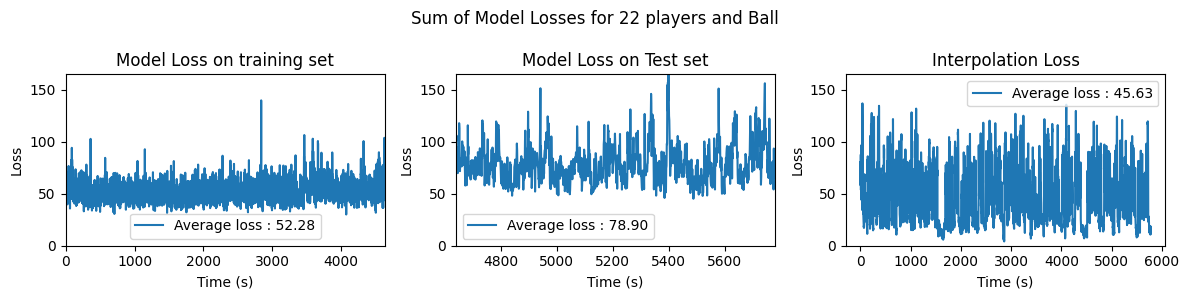

In [166]:
# Sum of losses
L = len(Game_dataset)-1
loss_model = [0] * (len(Game_dataset) - 1)
loss_interpolation = [0] * (len(Game_dataset) - 1)
for p in range(23):
    team = "home"
    if p>=11 and p<=21:
        team="away"
    loss_model_p, loss_interpolation_p = compute_losses(p, L, team)
    loss_model = [x + y for x, y in zip(loss_model, loss_model_p)]
    loss_interpolation = [x + y for x, y in zip(loss_interpolation, loss_interpolation_p)]
max_loss = max(max(loss_model), max(loss_interpolation))



# Create subplots for the two losses
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(loss_model, label = f'Average loss : {sum(loss_model[:4640]) / len(loss_model[:4640]):.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('Model Loss on training set')
plt.xlim(0, 4640)  # Set the x-axis limits
plt.ylim(0, max_loss)  
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(loss_model, label = f'Average loss : {sum(loss_model[4640:]) / len(loss_model[4640:]):.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('Model Loss on Test set')
plt.xlim(4640, len(loss_model))  # Set the x-axis limits
plt.ylim(0, max_loss)  # Set the y-axis limits
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(loss_interpolation, label = f'Average loss : {sum(loss_interpolation) / len(loss_interpolation):.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('Interpolation Loss')
plt.ylim(0, max_loss)  # Set the y-axis limits
plt.legend()

plt.suptitle('Sum of Model Losses for 22 players and Ball')
plt.tight_layout()
plt.show()

### Players individually

This section plots the losses between prediction and ground-truth position for each player of the Home team individually. We note that some models have been trained on a twice bigger dataset since they corresponded to a player in both home and away team. For these models ( 1, 4, 11, 12, 21, 23), the loss on the test set offers better results than the other models. 

In [163]:
def plot_losses(p):
    loss_model = [0] * (len(Game_dataset) - 1)
    loss_interpolation = [0] * (len(Game_dataset) - 1)

    loss_model_p, loss_interpolation_p = compute_losses(p, len(Game_dataset)-1, "home")
    loss_model = [x + y for x, y in zip(loss_model, loss_model_p)]
    loss_interpolation = [x + y for x, y in zip(loss_interpolation, loss_interpolation_p)]
    max_loss = max(max(loss_model), max(loss_interpolation))
    
    # Create subplots for the two losses
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    plt.plot(loss_model, label = f'Average loss : {sum(loss_model[:4640]) / len(loss_model[:4640]):.2f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.title('Model Loss on training set')
    plt.xlim(0, 4640)  # Set the x-axis limits
    plt.ylim(0, max_loss)  
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(loss_model, label = f'Average loss : {sum(loss_model[4640:]) / len(loss_model[4640:]):.2f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.title('Model Loss on Test set')
    plt.xlim(4640, len(loss_model))  # Set the x-axis limits
    plt.ylim(0, max_loss)  # Set the y-axis limits
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(loss_interpolation, label = f'Average loss : {sum(loss_model) / len(loss_model):.2f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.title('Interpolation Loss')
    plt.ylim(0, max_loss)  # Set the y-axis limits
    plt.legend()


    if p==0 or p==11:
        m = 1
    elif p == 22:
        m = 27
    else:
        role = Features_tensor[0][p][4:6].clone()
        m = place_in_compo(role)

    
    if p == 22:
        plt.suptitle(f'Model Losses for Ball - Model 27')
    elif p%11 == 0:
        plt.suptitle(f'Model Losses for goalkeeper - Model 1')
    else:
        plt.suptitle(f'Model Losses for player {p} - Model {m}')
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17672\2423935074.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype=torch.float32).clone().detach().unsqueeze(0)


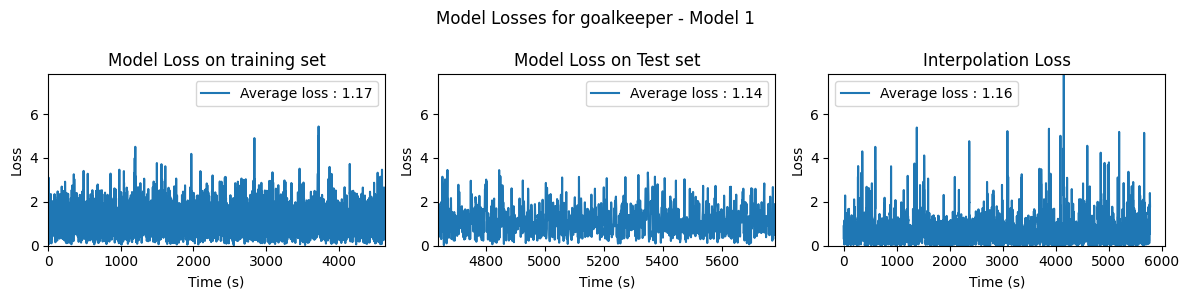

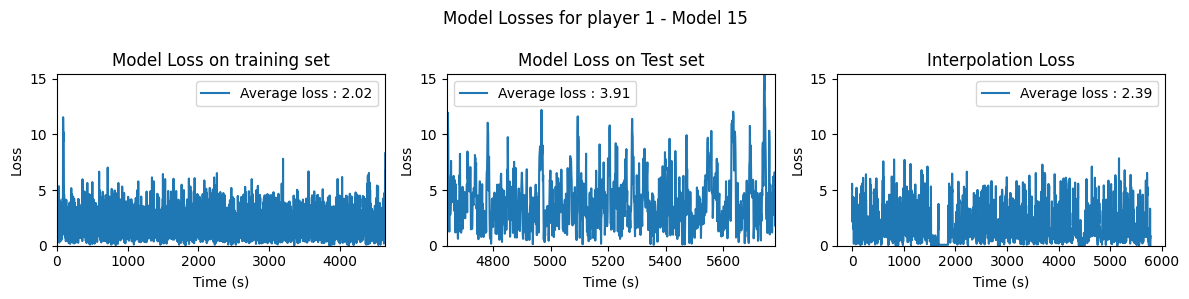

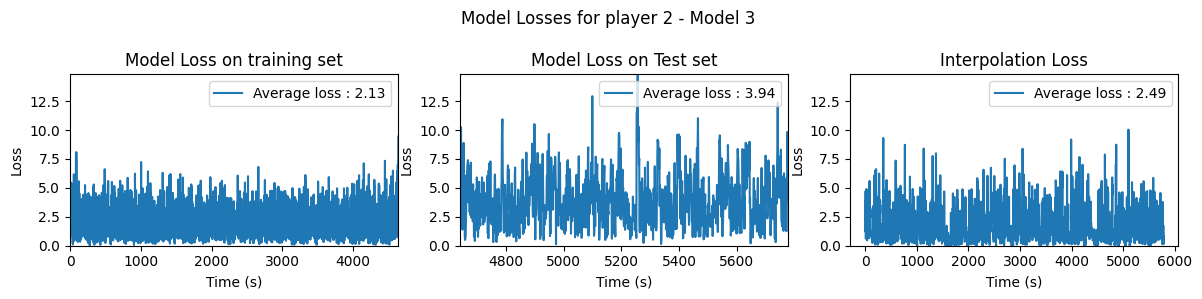

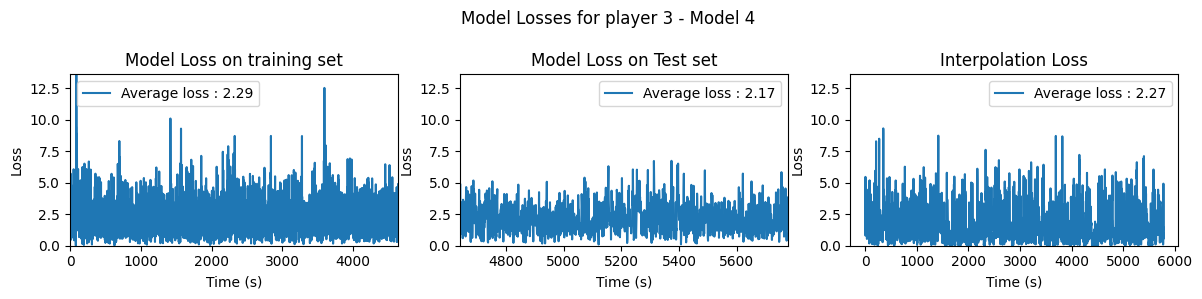

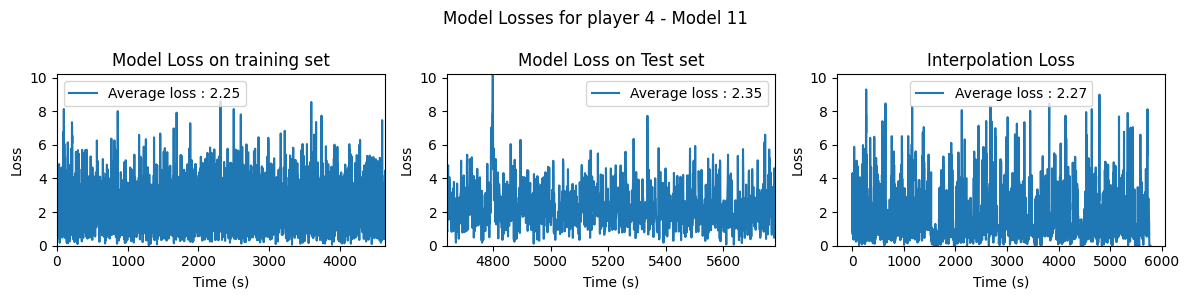

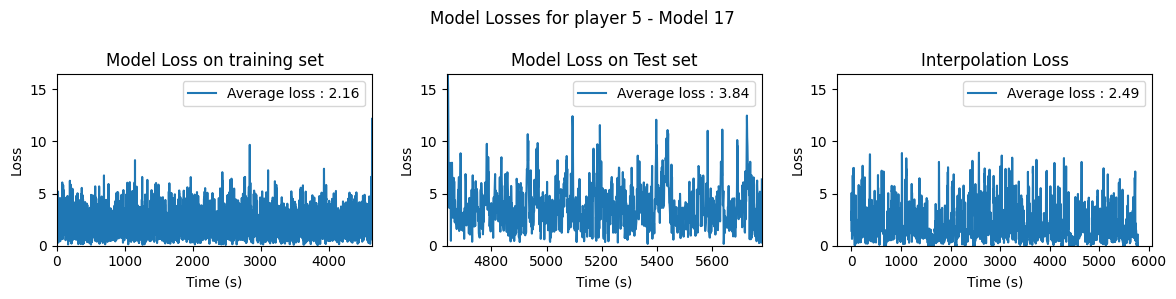

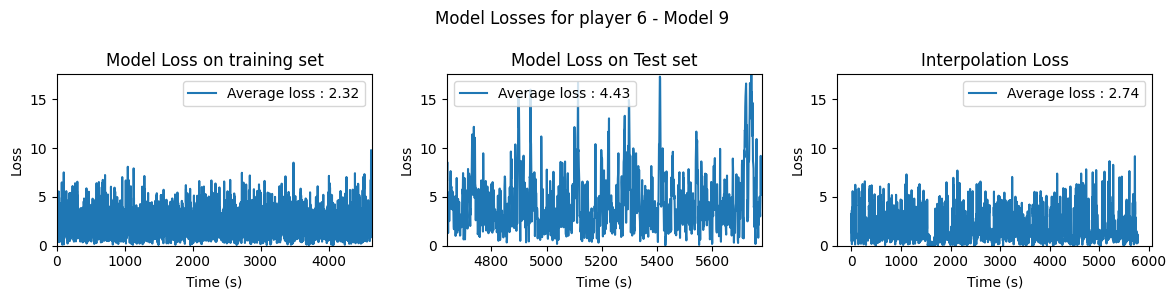

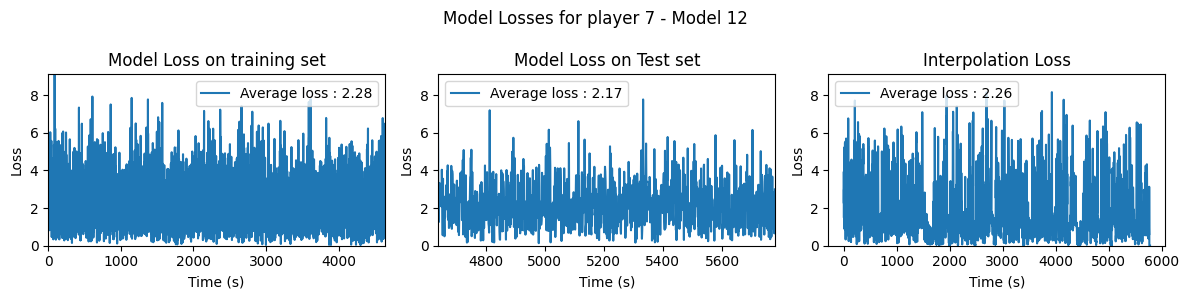

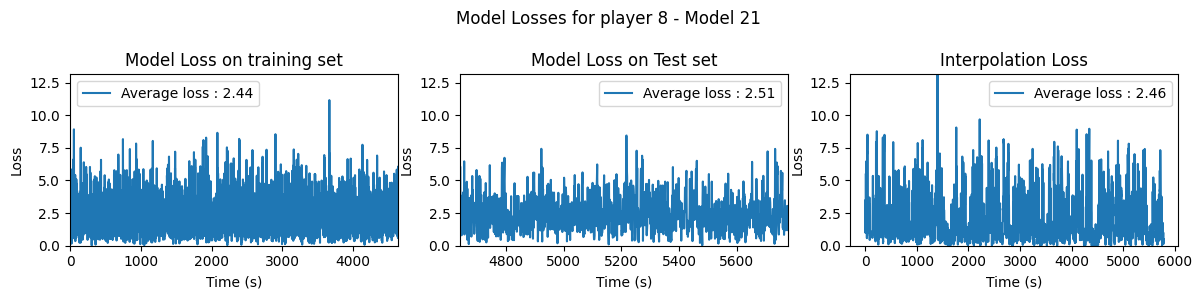

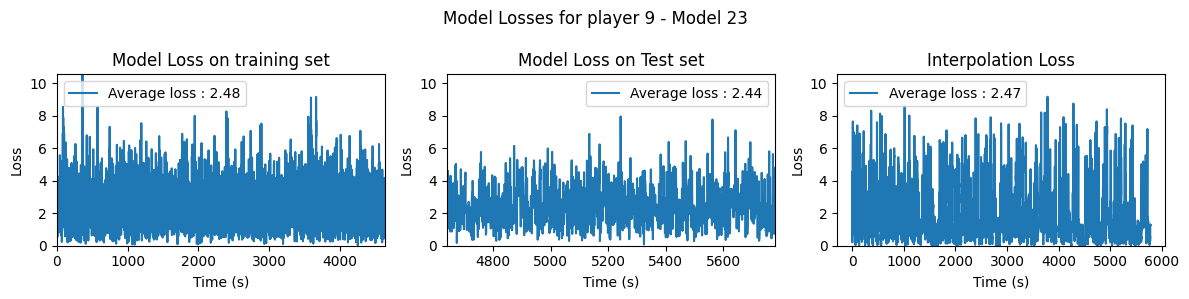

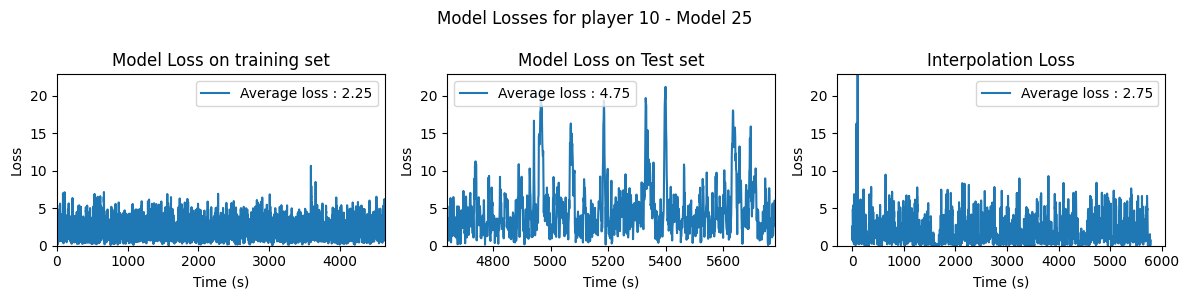

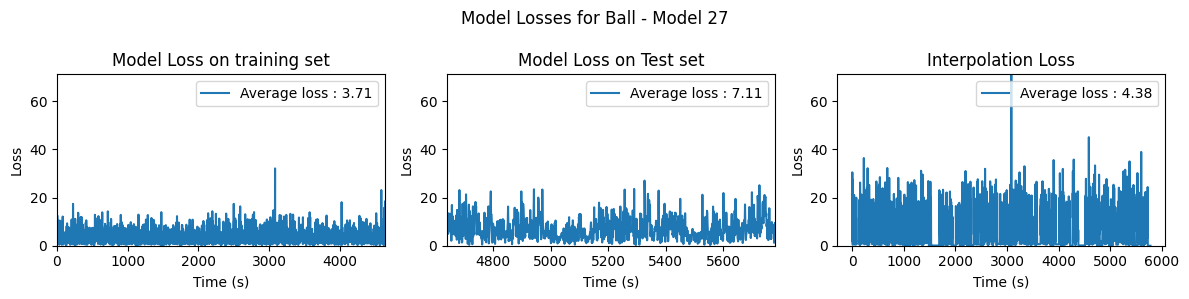

In [164]:
for i in range(11):
    plot_losses(i)
plot_losses(22)